In [3]:
import os

from skimage import io, transform

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils

import math
import matplotlib.pyplot as plt

import random


In [4]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device}")

Using cuda


In [5]:
IMAGE_SIZE = 80 #Actual frames = 1440. must be divisible by 4
IMAGE_CHANNELS = 3
LATENT_VECTOR_SIZE = 100

Set the random seed:

In [6]:
torch.manual_seed(1337)

# Preparing training data

In [13]:
class VetleDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, sample_count, image_dir, transform=None):
        """
        Arguments:
            sample_count (int): How many samples
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sample_count = sample_count
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return self.sample_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        frameno = str(idx+1).zfill(4)
        filename = "frame" + frameno + ".png"

        img_name = os.path.join(self.image_dir,
                                filename)
        image = torchvision.io.read_image(img_name).float()
        

        if self.transform:
            image = self.transform(image)

        # Return image with a label. We won't use it, but it seems like tensorflow expects it
        return [image,0]

In [10]:
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.Normalize(128,128)])

In [14]:
dataset = VetleDataset(2905, "assets/frames/", transform=transform)

Plot training data:

C:\Users\vmang\AppData\Local\Temp\ipykernel_18152\3385833128.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


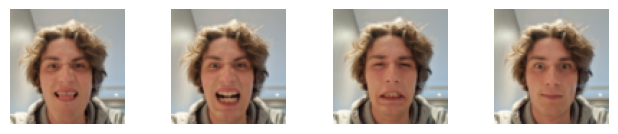

In [15]:
fig = plt.figure()
for plot_idx, dataset_idx  in enumerate(torch.randint(len(dataset), (4,))):
    sub = plt.subplot(1, 4, plot_idx+1)
    plt.tight_layout()
    sub.axis('off')
    image = dataset[dataset_idx.item()][0].permute(1,2,0)
    plt.imshow(image * 0.5 + 0.5)
fig.show()


Create data loader:

In [16]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)


# The models


## Discriminator

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(IMAGE_SIZE**2*IMAGE_CHANNELS, 256),
            nn.ReLU(),
            
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), IMAGE_CHANNELS*IMAGE_SIZE**2)
        output = self.model(x)
        return output

In [18]:
discriminator = Discriminator()

## Generator

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcnn = nn.Sequential(
            nn.Linear(in_features=LATENT_VECTOR_SIZE, out_features=128*(IMAGE_SIZE//4)**2)
        )
        
        self.conv = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        post_fcnn = self.fcnn(x)
        pre_cnn = post_fcnn.view(post_fcnn.size(0), 128, IMAGE_SIZE//4, IMAGE_SIZE//4)
        output = self.conv(pre_cnn)
        return output



In [20]:
generator = Generator()

# Training


## Hyperparameters

In [21]:
lr = 0.001
num_epochs = 100
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Loop

In [71]:
timeline = {
    "loss_discriminator":[],
    "loss_generator":[],
}
for epoch in range(num_epochs):
    print(epoch, end=" ")
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((real_samples.shape[0], 1))
        latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
        real_labels = torch.ones((batch_size, 1))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == len(train_loader) - 1:
            timeline["loss_discriminator"].append(loss_discriminator.detach())
            timeline["loss_generator"].append(loss_generator.detach())
            if epoch % 10 == 0:
                print("")
                print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")
           

0 
Epoch: 0 Loss D.: 0.05116753652691841
Epoch: 0 Loss G.: 87.07682037353516
1 2 3 4 5 6 7 8 9 10 
Epoch: 10 Loss D.: 0.017500322312116623
Epoch: 10 Loss G.: 6.055931568145752
11 12 13 14 15 16 17 18 19 20 
Epoch: 20 Loss D.: 0.014598886482417583
Epoch: 20 Loss G.: 5.444609642028809
21 22 23 24 25 26 27 28 29 30 
Epoch: 30 Loss D.: 0.051034606993198395
Epoch: 30 Loss G.: 8.611382484436035
31 32 33 34 35 36 37 38 39 40 
Epoch: 40 Loss D.: 0.033828675746917725
Epoch: 40 Loss G.: 5.6527018547058105
41 42 43 44 45 46 47 48 49 50 
Epoch: 50 Loss D.: 6.4815216064453125
Epoch: 50 Loss G.: 20.46323585510254
51 52 53 54 55 56 57 58 59 60 
Epoch: 60 Loss D.: 0.042810626327991486
Epoch: 60 Loss G.: 5.717164516448975
61 62 63 64 65 66 67 68 69 70 
Epoch: 70 Loss D.: 1.7202014923095703
Epoch: 70 Loss G.: 38.765960693359375
71 72 73 74 75 76 77 78 79 80 
Epoch: 80 Loss D.: 1.4454927444458008
Epoch: 80 Loss G.: 22.867000579833984
81 82 83 84 85 86 87 88 89 90 
Epoch: 90 Loss D.: 0.11524616926908493
E

# Results

C:\Users\vmang\AppData\Local\Temp\ipykernel_20096\582045452.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


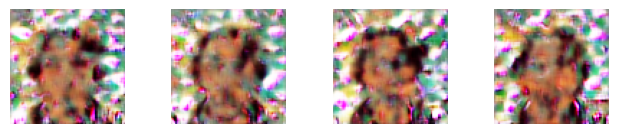

In [72]:
latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()
fig = plt.figure()
for plot_idx, dataset_idx  in enumerate(torch.randint(len(generated_samples), (4,))):
    sub = plt.subplot(1, 4, plot_idx+1)
    plt.tight_layout()
    sub.axis('off')
    image = generated_samples[dataset_idx.item()].permute(1,2,0)
    plt.imshow(image *0.5 + 0.5)
fig.show()


## Stats

C:\Users\vmang\AppData\Local\Temp\ipykernel_20096\3322973481.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  discriminator_plot.show()
C:\Users\vmang\AppData\Local\Temp\ipykernel_20096\3322973481.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  generator_plot.show()


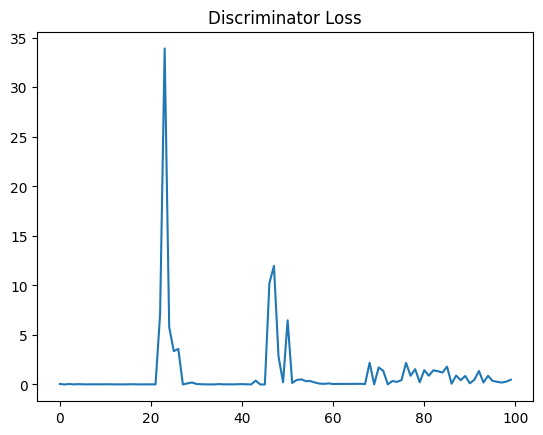

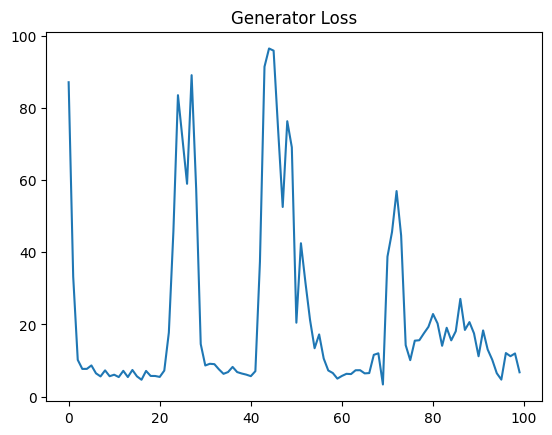

In [73]:
discriminator_plot = plt.figure()
plt.plot(range(0, num_epochs), timeline["loss_discriminator"])
plt.title("Discriminator Loss")
discriminator_plot.show()
generator_plot = plt.figure()
plt.plot(range(0, num_epochs), timeline["loss_generator"])
plt.title("Generator Loss")
generator_plot.show()

# Save model

In [23]:
SAVE = False
NAME = "GANgrud01"
path = f"saved/{NAME}.gangrud"
if SAVE:
    torch.save(generator.state_dict(), path)

## View saved model

In [24]:
saved_model = Generator()
saved_model.load_state_dict(torch.load(path))

FileNotFoundError: [Errno 2] No such file or directory: 'saved/GANgrud02.gangrud'

In [8]:
latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
generated_samples = saved_model(latent_space_samples)

generated_samples = generated_samples.detach()
fig = plt.figure()
for plot_idx, dataset_idx  in enumerate(torch.randint(len(generated_samples), (12,))):
    sub = plt.subplot(3, 4, plot_idx+1)
    plt.tight_layout()
    sub.axis('off')
    image = generated_samples[dataset_idx.item()].permute(1,2,0)
    plt.imshow(image *0.5 + 0.5)
fig.show()

NameError: name 'batch_size' is not defined